In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, constants
import migen as mg
import logging

%matplotlib inline

logger = logging.getLogger(__name__)

In [3]:
(
    14 + # cos: >0, > 1/2
    15 + # sin: >0
    4 + # dsin: >0
    3 # dcos: <0, >1/2
)

36

In [4]:
def minimax_linear_approximation(ab, f, f1i):
    """Minimax linear approximation

    returns 1st order polynomial coefficients m, n
    for stepwise linear minimax approximation mx + n of function f(x)
    between consecutive points in ab. The inverse of the
    derivative of f(x) is provided as f1i(x).
    """
    fab = f(ab)
    a, b = ab[:-1], ab[1:]
    fa, fb = fab[:-1], fab[1:]
    m = (fa - fb)/(a - b)
    c = f1i(m)
    fc = f(c)
    n = (fa + fc - m*(a + c))/2
    e = m*a + n - fa
    np.testing.assert_allclose(m*b + n - fb, e)
    np.testing.assert_allclose(m*c + n - fc, -e)
    #x = np.linspace(a, b, 100)
    #np.testing.assert_array_less(np.absolute(m*x + n - f(x)), np.ones_like(x)*1.00001*e)
    return m, n


class CosSin:
    """cos(z), sin(z) generator numerical model"""
    def __init__(self, z=18, x=15, zl=9, xd=4, a=0., meth=0, backoff=None):
        self.z = z  # total phase depth, unsigned
        self.x = x  # x width, leave out sign bit
        if zl is None:
            zl = z - 3
        assert zl >= 0
        self.zl = zl  # LUT phase bits, LUT address width
        assert xd >= 0
        self.xd = xd  # derivative coefficient bit width in LUT
        self.a = a  # dither amplitude
        self.z_max = 1 << z
        print("LUT: {} deep, {} wide".format(zl, 2*(x + xd - 1)))
        if backoff is None:
            backoff = min(3, (1 << x - 1) - 1)
        self.x_max = (1 << x) - backoff
        # LUT sin/cos data
        self.meth = meth
        if meth in (0, 3):  # midpoint
            # use mid point of the phase bins to avoid needing an additional entry for pi/4
            a = np.exp(np.pi/4*1j/(1 << zl)*(np.arange(1 << zl) + .5))
            cs = np.round(self.x_max*a)
            csd = np.round(np.pi/4/(1 << x - xd)*cs)
        elif meth == 1:  # mean
            a = np.exp(np.pi/4*1j/(1 << zl)*(np.arange((1 << zl) + 1)))
            cs = np.round(self.x_max/2*(a[:-1] + a[1:]))
            csd = np.round(np.diff(a)*(1 << xd + zl)*-1j)
        elif meth == 2:  # minimax
            ab = np.pi/4/(1 << zl)*np.arange((1 << zl) + 1)
            if xd:
                cm, cn = minimax_linear_approximation(ab, np.cos, lambda x: np.arcsin(-x))
                sm, sn = minimax_linear_approximation(ab, np.sin, lambda x: np.arccos(x))
                csd = cm + 1j*sm
                cs = cn + 1j*sn + csd*(ab[:-1] + ab[1:])/2
                # cs = cn + 1j*sn + csd*ab[:-1]
                csd = np.round((1 << xd)*np.pi/4/1j*csd)
            else:
                cs = np.exp(1j*ab)
                cs = (cs[1:] + cs[:-1])/2
            cs = np.round(self.x_max*cs)
        else:
            raise ValueError()
        self.c, self.s = cs.real.astype(np.int32), cs.imag.astype(np.int32)
        if xd:
            # derivative LUT, includes the 2pi/(1<<3) factor
            self.cd, self.sd = csd.real.astype(np.int32), csd.imag.astype(np.int32)

    def xy(self, z):
        """Calculate cos(z) and sin(z)"""
        z = z + self.a*np.random.triangular(-1, 0, 1, len(z))
        z = np.mod(np.round(z).astype(np.int32), self.z_max)
        # 3 MSBs: octant
        z0, z1, z2 = [((z >> self.z - 1 - i) & 1) for i in range(3)]
        # LSBs: phase, map into first octant
        z = z & ~(7 << self.z - 3)
        # z2: pi/2 - z or z
        # The LUT lookup is biased low by 1 to fit the range.
        # To compensate we bias the interpolation high by 1 below.
        z = np.where(z2, (1 << self.z - 3) - z - 1, z)
        # do LUT lookup
        zk = self.z - 3 - self.zl
        zl = z >> zk
        c, s = self.c[zl], self.s[zl]
        if self.xd:
            # derivative lookup
            # z2 to compensate the -1 in the mapping above
            zd = (z & ((1 << zk) - 1)) + z2 - (1 << zk - 1)
            if self.meth == 3:  # alternative with one more multiplication but no derivative lut
                zd = np.round(zd*np.pi/4).astype(np.int32)
                cd, sd = zd*(c >> self.x - self.xd), zd*(s >> self.x - self.xd)
            else:
                cd, sd = zd*self.cd[zl], zd*self.sd[zl]
            zq = self.z - 3 - (self.x - self.xd)
            if zq > 0:  # introduce rounding bias
                qb = (1 << zq - 1) - 1
                sd, cd = sd + qb, cd + qb
                sd, cd = sd >> zq, cd >> zq
            else:
                sd, cd = sd << -zq, cd << -zq
            c, s = c - sd, s + cd
        # unmap octant bits
        # z1 ^ z2: swap sin/cos
        q = z1 ^ z2
        # z0 ^ z1: invert x
        x = (1 - 2*(z0 ^ z1))*np.where(q, s, c)
        # z0: invert y
        y = (1 - 2*z0)*np.where(q, c, s)
        return x, y

    def xy_err(self):
        """Return maximum quadrature error, rms magnitude error, and max magnitude error"""
        z = np.arange(self.z_max)
        x, y = self.xy(z)
        xy = x + 1j*y
        xyp = np.fft.fft(xy)
        assert np.argmax(np.absolute(xyp)) == 1
        xyp[1], pp = 0., xyp[1]
        xye = np.fft.ifft(xyp)
        xye2 = np.absolute(xye)
        return xyp, xye, np.fabs(np.r_[xye.real, xye.imag]).max(), (xye2**2).mean()**.5, xye2.max()

    def ppt(self):
        """return primary phase truncation spur power dbc"""
        # https://www.analog.com/media/en/technical-documentation/application-notes/an-1396.pdf
        p = self.z  # phase truncation
        l = 48  # ftw width (i.e. large)
        return 20*np.log10(np.absolute(np.sin(np.pi/2**l)/np.sin(np.pi*(2**p - 1)/2**l)))

# minimal verification
c = CosSin(z=13, x=13, zl=None, xd=0)
assert np.diff(c.s).max() == 7., np.diff(c.s).max()
pxye, xye, *ce = c.xy_err()
assert ce[0] <= .51, ce
assert ce[1] <= .5, ce
assert ce[2] < 1, ce

LUT: 10 deep, 24 wide


LUT: 10 deep, 36 wide
ppt -114.391381785
iq max err, rms err, mag max err (1.4081905582041245, 0.62665720880740294, 1.7128606753636717)
-113.379145132 327681


(-140, 0.0)

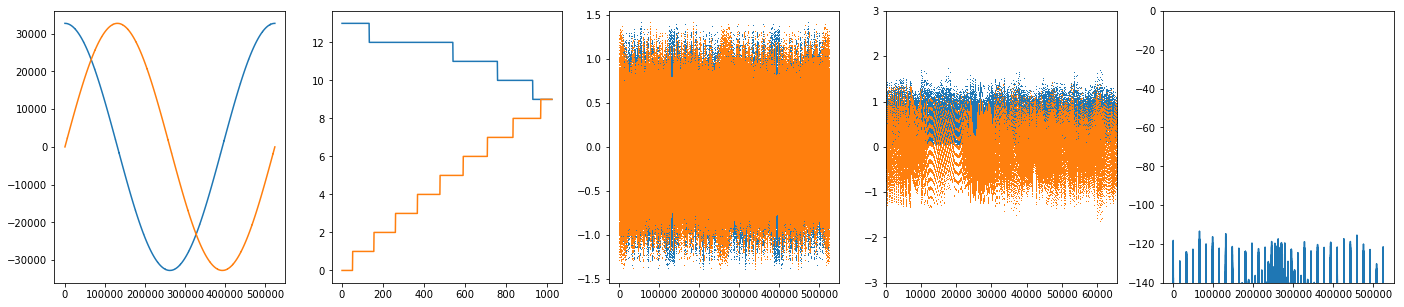

In [52]:
#c = CosSin()
c = CosSin(z=19, zl=10)
#c = CosSin(z=12, zl=0, x=15, xd=8)  # check interpolation
#c = CosSin(z=15, zl=11, x=11, xd=1)  # check rounding bias
#c = CosSin(z=13, zl=9, x=15, xd=1)  # check rounding bias
#c = CosSin(z=20, zl=9, x=15, xd=12)  # check rounding bias
#c = CosSin(z=13, zl=9, x=12, xd=3)  # migen test
#c = CosSin(z=20, zl=10)  # wider bram
#c = CosSin(a=4.)  # dither
#c = CosSin(z=16, zl=8, x=13, xd=3)  # 14 bit
#c = CosSin(z=14, zl=6, x=11, xd=3)  # 12 bit

print("ppt", c.ppt())
print("iq max err, rms err, mag max err", c.xy_err()[2:])

z = np.arange(1 << c.z)
x, y = c.xy(z)
xy = x + 1j*y
xyep, xye, *ce = c.xy_err()
xy_err_p = np.clip(np.absolute(xyep)/c.x_max/len(xyep), 1e-13, None)
print(20*np.log10(xy_err_p.max()), np.argmax(xy_err_p))

fig, ax = plt.subplots(1, 5, figsize=(24, 5))

ax[0].plot(xy.real)
ax[0].plot(xy.imag)

if c.xd:
    ax[1].plot(c.cd)
    ax[1].plot(c.sd)

ax[2].plot(xye.real, ",")
ax[2].plot(xye.imag, ",")

ax[3].plot(np.absolute(xye), ",")
ax[3].plot((np.angle(xy) - np.angle(xy - xye))*c.x_max, ",")
ax[3].set_ylim(-3, 3)
ax[3].set_xlim(0, 1 << c.z - 3)
#ax[3].set_xlim(0, 500)

ax[4].plot(20*np.log10(np.fft.fftshift(xy_err_p)))
ax[4].set_ylim(-140, 0.)
#ax[4].set_xscale("log")

In [50]:
np.absolute(np.round(((xy[np.argmax(np.absolute(xy))]*(1 << 15)) + (1+1j)*(1 << 14)))/(1 << 15))

65536.808989300058

In [51]:
i = np.argsort(np.absolute(xy_err_p))[-10:]
(i-17)/(1<<12), xyep[i]/c.x_max/len(xyep)

(array([ 125.98828125,    1.99023438,    1.98828125,   63.99511719,
         125.98632812,  125.98925781,    1.98632812,    1.98925781,
           2.00488281,  126.00488281]),
 array([ -1.82709861e-06 +9.04237229e-08j,
          1.84183287e-06 +8.99396846e-08j,
          1.85472232e-06 +9.04237229e-08j,
          1.87164591e-06 +5.05548929e-08j,
          2.03756023e-06 -1.01068813e-07j,
          2.05905929e-06 -1.01791220e-07j,
         -2.07695462e-06 -1.01068813e-07j,
         -2.08645263e-06 -1.01791220e-07j,
          2.75788716e-06 +1.36747139e-07j,  -2.80824215e-06 +1.36747139e-07j]))

In [47]:
np.argmax(np.absolute(xye))

64638

-90.441824972


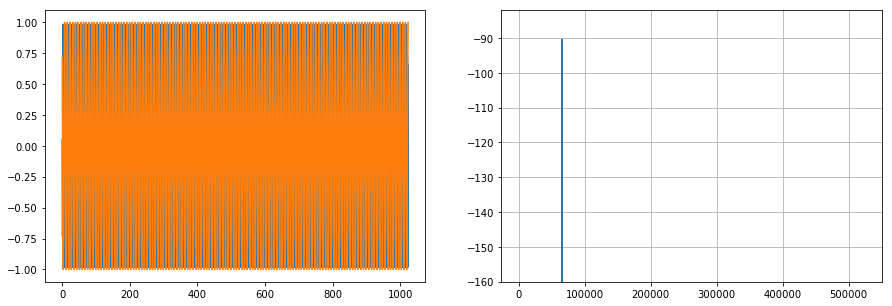

In [48]:
# play around with the numerical model

self = c
#ftw, f, z0 = 20, 0x12345, 0
ftw, f, z0 = c.z, 1 << c.z - c.zl - 1, 4
#ftw, f, z0 = c.z, np.argmax(xy_err_p)*2, 0
#ftw, f, z0 = c.z, 1 << c.z - 3 - 1, 1
ftw, f, z0 = c.z, 1 << c.z - 3, np.argmax(np.absolute(xye))
i = np.arange(1 << ftw, dtype=np.int64)
x, y = self.xy(np.arange(c.z_max))
z = ((z0 + i*f) & ((1 << ftw) - 1))
zi = z >> ftw - c.z
# dither
zi = (zi + 0*np.random.randint(-1, 1, size=len(z))) & ((1 << c.z) - 1)
p = x[zi] + 1j*y[zi]
pf = np.fft.fft(p)/c.x_max/len(p)
pf /= pf[f]
pf[f] = 0
sfdr = 20*np.log10(np.absolute(np.absolute(pf).max()))
print(sfdr)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.fft.ifft(pf)[:1024].real*len(pf)*c.x_max)
ax[0].plot(p.real[:1024]/c.x_max)
#ax[1].psd((p - q), NFFT=len(p))
#ax[1].psd(p/len(p)**.5, NFFT=len(p))
ax[1].plot(20*np.log10(np.clip(np.absolute(np.fft.fftshift(pf)), 1e-13, None)))
ax[1].set_ylim(-160, None)
ax[1].grid()
#ax[1].plot(np.fft.fftfreq(*p.shape), np.absolute(np.fft.fft(p))/len(p))
#ax[1].set_ylim(1e-7, 1.)
#ax[1].set_yscale("log")
#ax[1].set_xlim(1e-7, 1)
#ax[1].set_xscale("log")
ff = f/(1 << ftw)*2
#plt.xlim(ff - 1e-3, ff + 1e-3)

In [58]:
class CosSinGen(mg.Module):
    """cos(z), sin(z) generator using a block ROM and linear interpolation

    For background information about an alternative way of computing
    trigonometric functions without multipliers and large ROM, see:

    P. K. Meher et al., "50 Years of CORDIC: Algorithms, Architectures,
    and Applications"
    in IEEE Transactions on Circuits and Systems I: Regular Papers, vol. 56, no. 9,
    pp. 1893-1907, Sept. 2009. doi: 10.1109/TCSI.2009.2025803
    https://eprints.soton.ac.uk/267873/1/tcas1_cordic_review.pdf

    For other implementations of trigonometric function generators, see

    https://www.xilinx.com/products/intellectual-property/dds_compiler.html#documentation
    https://www.intel.com/content/dam/altera-www/global/en_US/pdfs/literature/ug/ug_nco.pdf

    The implementation is as follows:

    1. Extract the 3 MSBs and save for later unmapping.
    2. Map the remaining LSBs into the first octant [0, pi/4[
       (conditional phase flip)
    3. Use the coarse `zl` MSBs of the first octant phase to look up
       cos(z), sin(z), cos'(z), sin'(z) in block ROM.
    4. Interpolate with the residual LSBs as cos(z + dz) = cos(z) + dz*cos'(z).
    5. Unmap the octant (cos sign flip, sin sign flip, cos/sin swap).

    The default values for the constructor parameters yield a 100 dBc
    SFDR cons/sin generator with 18 bit phase and 16 bit outputs using
    one 9x36 bit block ROM (one RAMB18xx in read-only SDP mode on several
    Xilinx architectures), and 4x6 and 3x6 bit fabric multipliers for the
    interpolation. It runs at > 250 MHz on an A7-2.

    Dithering the input phase improves the SFDR further.

    The output is combinatorial and it helps to add another pipeline
    stage.

    Multiplication by a amplitude scaling factor (`a*cos(z)`)
    and generation of the phase input (e.g. a phase accumulator)
    is to be implemented elsewhere.

    Using a second port of an existing LUT is supported by passing the
    existing `Memory` as `use_lut`.
    """
    def __init__(self, z=18, x=15, zl=9, xd=4, backoff=None, use_lut=None):
        self.latency = 0  # computed later
        self.z = mg.Signal(z)  # input phase
        self.x = mg.Signal((x + 1, True), reset_less=True)  # output cos(z)
        self.y = mg.Signal((x + 1, True), reset_less=True)  # output sin(z)

        ###

        if backoff is None:
            backoff = min(3, (1 << x - 1) - 1)
        self.x_max = (1 << x) - backoff

        # LUT depth
        if zl is None:
            zl = z - 3
        assert zl >= 0

        # generate the cos/sin LUT
        a = np.exp(1j*np.pi/4/(1 << zl)*(np.arange(1 << zl) + .5))
        cs = np.round(self.x_max*a)
        csd = np.round(np.pi/4/(1 << x - xd)*cs)

        lut_init = []
        for csi, csdi in zip(cs, csd):
            # save a bit by noticing that cos(z) > 1/2 for 0 < z < pi/4
            xy = csi - (1 << x - 1)
            xi, yi = int(xy.real), int(xy.imag)
            assert 0 <= xi < 1 << x - 1, csi
            assert 0 <= yi < 1 << x, csi
            lut_init.append(xi | (yi << x - 1))
            if xd:
                # derivative LUT
                # save a bit again
                xyd = csdi - (1 << xd - 1)
                xid, yid = int(xyd.real), int(xyd.imag)
                assert 0 <= xid < 1 << xd - 1, csdi
                assert 0 <= yid < 1 << xd, csdi
                lut_init[-1] |= (xid << 2*x - 1) | (yid << 2*x + xd - 2)

        # LUT ROM
        mem_layout = [("x", x - 1), ("y", x)]
        if xd:
            mem_layout.extend([("xd", xd - 1), ("yd", xd)])
        lut_data = mg.Record(mem_layout, reset_less=True)
        assert len(lut_init) == 1 << zl
        assert all(0 <= _ < 1 << len(lut_data) for _ in lut_init)
        logger.info("CosSin LUT {} bit deep, {} bit wide".format(
            zl, len(lut_data)))
        if use_lut is not None:
            assert all(a == b for a, b in zip(use_lut.init, lut_init))
            self.lut = use_lut
        else:
            self.lut = mg.Memory(len(lut_data), 1 << zl, init=lut_init)
            self.specials += self.lut
        lut_port = self.lut.get_port()
        self.specials += lut_port

        self.sync += [
            # use BRAM output data register
            lut_data.raw_bits().eq(lut_port.dat_r),
        ]
        self.latency += 1  # mem dat_r output register

        # compute LUT address
        # 3 MSBs: octant
        # LSBs: phase, maped into first octant
        za = mg.Signal(z - 3)
        self.comb += [
            za.eq(mg.Mux(
                self.z[-3], (1 << z - 3) - 1 - self.z[:-3], self.z[:-3])),
            lut_port.adr.eq(za[-zl:]),
        ]
        self.latency += 1  # mem address register

        if xd:  # apply linear interpolation
            zk = z - 3 - zl
            zd = mg.Signal((zk + 1, True), reset_less=True)
            self.comb += zd.eq(za[:zk] - (1 << zk - 1) + self.z[-3])
            zd = self.pipe(zd, self.latency)
            # add a rounding bias
            zq = z - 3 - x + xd
            assert zq > 0
            qb = (1 << zq - 1) - 1
            lxd = mg.Signal((xd + zk, True), reset_less=True)
            lyd = mg.Signal((xd + zk, True), reset_less=True)
            self.sync += [
                lxd.eq(zd*(lut_data.xd | (1 << xd - 1))),
                lyd.eq(zd*lut_data.yd),
            ]
            x1 = self.pipe(self.pipe(lut_data.x | (1 << x - 1), 1) - ((lyd + qb) >> zq), 1)
            y1 = self.pipe(self.pipe(lut_data.y, 1) + ((lxd + qb) >> zq), 1)
            self.latency += 2
        else:
            x1 = self.pipe(lut_data.x | (1 << x - 1), 0)
            y1 = self.pipe(lut_data.y, 0)

        # unmap octant
        zq = self.pipe(mg.Cat(self.z[-3] ^ self.z[-2],
                              self.z[-2] ^ self.z[-1], self.z[-1]), self.latency)
        # intermediate unmapping signals
        x2 = self.pipe(mg.Mux(zq[0], y1, x1), 0)
        y2 = self.pipe(mg.Mux(zq[0], x1, y1), 0)
        self.comb += [
            self.x.eq(mg.Mux(zq[1], -x2, x2)),
            self.y.eq(mg.Mux(zq[2], -y2, y2)),
        ]

    def pipe(self, x, n=0):
        """Create `n` pipeline register stages for signal x
        and return final stage"""
        k = mg.value_bits_sign(x)
        x, x0 = mg.Signal(k, reset_less=True), x
        self.comb += x.eq(x0)
        for i in range(n):
            x, x0 = mg.Signal(k, reset_less=True), x
            self.sync += x.eq(x0)
        return x

    def log(self, z, xy):
        """Run self for each value of `z` and record output values into `xy`"""
        if z is None:
            z = np.arange(1 << len(self.z))
        z = np.r_[z, (0,)*self.latency]
        for i, zi in enumerate(z):
            yield self.z.eq(int(zi))
            yield
            if i >= self.latency:
                x = yield self.x
                y = yield self.y
                xy.append((x, y))

    def xy_err(self, xy):
        """Given the `xy` output of all possible `z` values,
        calculate error, maximum quadrature error, rms magnitude error,
        and maximum magnitude error."""
        z = np.arange(1 << len(self.z))
        x, y = np.array(xy).T
        xy = x + 1j*y
        pxy = np.fft.fft(xy)
        assert np.argmax(np.absolute(pxy)) == 1
        pxy[1] = 0.
        xye = np.fft.ifft(pxy)
        xye2 = np.absolute(xye)
        assert xye.mean() < 1e-3
        return (xye, np.fabs(np.r_[xye.real, xye.imag]).max(),
                (xye2**2).mean()**.5, xye2.max())

    def verify(self):
        """Verify that the numerical model and the gateware
        implementation are equivalent."""
        co = CosSin(z=len(self.z), x=len(self.x) - 1,
                    zl=mg.log2_int(self.lut.depth),
                    xd=self.lut.width//2 - len(self.x) + 2)
        z = np.arange(1 << len(self.z))
        xy0 = np.array(co.xy(z))
        xy = []
        mg.Simulator(self, [self.log(z, xy)]).run()
        xy = np.array(xy).T
        np.testing.assert_allclose(xy, xy0)
        return xy

In [59]:
c = CosSinGen()
q, p = 0, (1 << 36) - 1
for _ in c.lut.init:
    #print("{:#011x}".format(_))
    q |= _
    p &= _
print("{:#011x} {:#011x}".format(q, p))

0xfffffffff 0x000000000


In [62]:
CosSinGen(z=5, zl=2, x=2, xd=0).verify()
CosSinGen(z=5, zl=2, x=23, xd=0).verify()
CosSinGen(z=10, zl=6, x=9, xd=3).verify()
CosSinGen(z=10, zl=3, x=9, xd=3).verify()
CosSinGen(z=13, zl=9, x=12, xd=3).verify()

LUT: 2 deep, 2 wide
LUT: 2 deep, 44 wide
LUT: 6 deep, 22 wide
LUT: 3 deep, 22 wide
LUT: 9 deep, 28 wide


array([[4093, 4093, 4093, ..., 4093, 4093, 4093],
       [   0,    3,    6, ...,   -9,   -6,   -3]])

LUT: 9 deep, 36 wide


[1.9178429854987114, 0.77546523241247811, 2.3082365513865457]

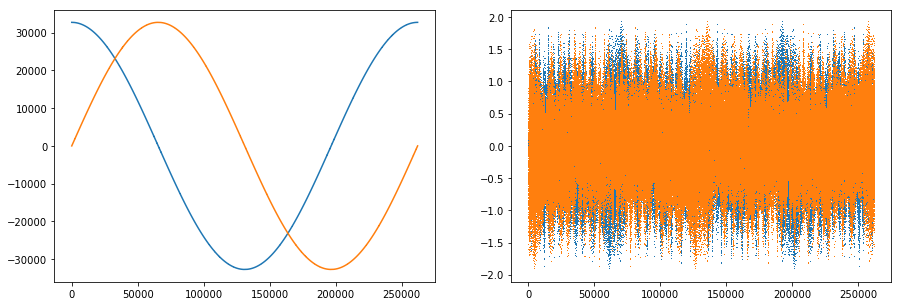

In [261]:
sincos = CosSinGen()
xy = sincos.verify().T
xye, *_ = sincos.xy_err(xy)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(xy)
ax[1].plot(xye.real, ",")
ax[1].plot(xye.imag, ",")
_

In [51]:
sincos = CosSinGen()
o = mg.fhdl.verilog.convert(sincos, ios={sincos.z, sincos.x, sincos.y})
print(o.main_source)
print(sincos.latency)

/* Machine-generated using Migen */
module top(
	input [17:0] z,
	output signed [15:0] x,
	output signed [15:0] y,
	input sys_clk,
	input sys_rst
);

reg [13:0] lut_data_x = 14'd0;
reg [14:0] lut_data_y = 15'd0;
reg [2:0] lut_data_xd = 3'd0;
reg [3:0] lut_data_yd = 4'd0;
wire [8:0] adr;
wire [35:0] dat_r;
wire [14:0] za;
wire signed [6:0] zd;
wire signed [6:0] zd_cossingen0;
reg signed [6:0] zd_cossingen1 = 7'sd0;
reg signed [6:0] zd_cossingen2 = 7'sd0;
reg signed [9:0] lxd = 10'sd0;
reg signed [9:0] lyd = 10'sd0;
wire [14:0] cossingen0;
reg [14:0] cossingen1 = 15'd0;
wire signed [16:0] x1_cossingen0;
reg signed [16:0] x1_cossingen1 = 17'sd0;
wire [14:0] cossingen2;
reg [14:0] cossingen3 = 15'd0;
wire signed [16:0] y1_cossingen0;
reg signed [16:0] y1_cossingen1 = 17'sd0;
wire [2:0] zq_cossingen0;
reg [2:0] zq_cossingen1 = 3'd0;
reg [2:0] zq_cossingen2 = 3'd0;
reg [2:0] zq_cossingen3 = 3'd0;
reg [2:0] zq_cossingen4 = 3'd0;
wire signed [16:0] x2_cossingen;
wire signed [16:0] y2_cossingen

In [857]:
# https://www.analog.com/media/en/technical-documentation/application-notes/an-1396.pdf
p = 18  # phase truncation
l = 32  # ftw width
# PPT spur power
20*np.log10(np.absolute(np.sin(np.pi/2**l)/np.sin(np.pi*(2**p - 1)/2**l)))

-108.37076525170509

-101.915077603


[2.0649886675328162, 0.918016260761643, 2.3724908050825526]

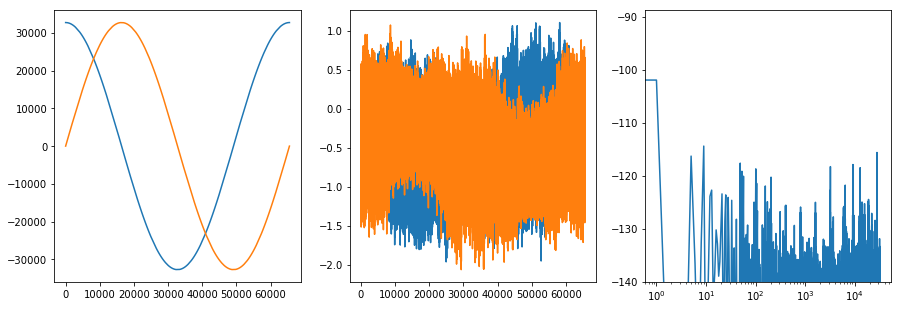

In [131]:
# Compare with migen CORDIC

from misoc.cores.cordic import Cordic
sincos = Cordic(width=16, widthz=16, guard=None, eval_mode="pipelined")

def log(self, z, xy):
    if z is None:
        z = np.arange(1 << len(self.zi))
    z = np.r_[z, (0,)*self.latency]
    yield self.xi.eq(int((1 << len(self.xi) - 1)/self.gain))
    for i, zi in enumerate(z):
        yield self.zi.eq(int(zi))
        yield
        if i >= self.latency:
            x = yield self.xo
            y = yield self.yo
            xy.append((x, y))

def xy_err(self, xy):
    z = np.arange(1 << len(self.zi)) + .5
    x, y = np.array(xy).T
    xy = x + 1j*y
    x_max = (1 << 9) - 1
    x_max = max(x)
    xye = xy - x_max*np.exp(2j*np.pi*(z - .5)/len(z))
    xye2 = np.absolute(xye)
    assert xye.mean() < 1e-3
    return (xye, np.fabs(np.r_[xye.real, xye.imag]).max(),
            (xye2**2).mean()**.5, xye2.max())

xy = []
with mg.Simulator(sincos, [log(sincos, None, xy)]) as sim:
    sim.run()
xy = np.array(xy)
xye, *_ = xy_err(sincos, xy)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(xy)
ax[1].plot(xye.real)
ax[1].plot(xye.imag)
xy_err_p = 20*np.log10(np.absolute(np.fft.fft(xye)/c.x_max/len(xye)))
print(xy_err_p[1:].max())
ax[2].plot(xy_err_p[:len(xy_err_p)//2])
ax[2].set_ylim(-140, None)
ax[2].set_xscale("log")
_